<a href="https://colab.research.google.com/github/shenjiejie2017/telcUserChurn/blob/main/User_Churn_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***User Churn Prediction***

## User retention is important for many companies. In this project we will try to build supervised learning models to predict user retention (churn or not). Furthermore, we will try to find some top influencing factors to help companies finding solutions to boost user retention.

# Part 0: Import files and load data

In [340]:
# import files
import pandas as pd
import numpy as np
import imblearn
import warnings
import matplotlib.pyplot as plt
import matplotlib 
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 

# show options
pd.set_option('display.max_columns', None) #show all columns
warnings.filterwarnings('ignore') # don't show warnings

In [341]:
# install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [342]:
#Load data
link = 'https://drive.google.com/open?id=11HWBoW1SRdXcKSSYKbsKlyu9fTf_NnIR'

fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) # replace the id with id of file you want to access
file.GetContentFile('churn.all')  
churn_df = pd.read_csv('churn.all')

# Part 1: Exploratory Data Analysis (EDA)

### Overall data EDA



In [343]:
#Take a look at data
churn_df.head()

state  account_length  area_code phone_number intl_plan voice_mail_plan  \
0    KS             128        415     382-4657        no             yes   
1    OH             107        415     371-7191        no             yes   
2    NJ             137        415     358-1921        no              no   
3    OH              84        408     375-9999       yes              no   
4    OK              75        415     330-6626       yes              no   

   number_vmail_messages  total_day_minutes  total_day_calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
0             45.07              197.4               99             16.78   
1             27.47              195.5              103             16.62   
2             41.38              121.2              110             10.30   
3             50.90               61.9               88              5.26   
4             28.34              148.3              122             12.61   

   total_night_minutes  total_night_calls  total_night_charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   total_intl_minutes  total_intl_calls  total_intl_charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   number_customer_service_calls  churned  
0                              1   False.  
1                              1   False.  
2                              0   False.  
3                              2   False.  
4                              3   False.

In [344]:
#Take a look at data shape
print (f"Num of rows: {churn_df.shape[0]}") 
print (f"Num of columns: {churn_df.shape[1]}") 


Num of rows: 5000
Num of columns: 21


In [345]:
#Take a look at data column types
churn_df.dtypes

state                             object
account_length                     int64
area_code                          int64
phone_number                      object
intl_plan                         object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churned                           object
dtype: object

In [346]:
#Take a look at statistic properties
churn_df.describe()

account_length    area_code  number_vmail_messages  total_day_minutes  \
count      5000.00000  5000.000000            5000.000000        5000.000000   
mean        100.25860   436.911400               7.755200         180.288900   
std          39.69456    42.209182              13.546393          53.894699   
min           1.00000   408.000000               0.000000           0.000000   
25%          73.00000   408.000000               0.000000         143.700000   
50%         100.00000   415.000000               0.000000         180.100000   
75%         127.00000   415.000000              17.000000         216.200000   
max         243.00000   510.000000              52.000000         351.500000   

       total_day_calls  total_day_charge  total_eve_minutes  total_eve_calls  \
count      5000.000000       5000.000000        5000.000000      5000.000000   
mean        100.029400         30.649668         200.636560       100.191000   
std          19.831197          9.162069          50.551309        19.826496   
min           0.000000          0.000000           0.000000         0.000000   
25%          87.000000         24.430000         166.375000        87.000000   
50%         100.000000         30.620000         201.000000       100.000000   
75%         113.000000         36.750000         234.100000       114.000000   
max         165.000000         59.760000         363.700000       170.000000   

       total_eve_charge  total_night_minutes  total_night_calls  \
count       5000.000000          5000.000000        5000.000000   
mean          17.054322           200.391620          99.919200   
std            4.296843            50.527789          19.958686   
min            0.000000             0.000000           0.000000   
25%           14.140000           166.900000          87.000000   
50%           17.090000           200.400000         100.000000   
75%           19.900000           234.700000         113.000000   
max           30.910000           395.000000         175.000000   

       total_night_charge  total_intl_minutes  total_intl_calls  \
count         5000.000000         5000.000000       5000.000000   
mean             9.017732           10.261780          4.435200   
std              2.273763            2.761396          2.456788   
min              0.000000            0.000000          0.000000   
25%              7.510000            8.500000          3.000000   
50%              9.020000           10.300000          4.000000   
75%             10.560000           12.000000          6.000000   
max             17.770000           20.000000         20.000000   

       total_intl_charge  number_customer_service_calls  
count        5000.000000                    5000.000000  
mean            2.771196                       1.570400  
std             0.745514                       1.306363  
min             0.000000                       0.000000  
25%             2.300000                       1.000000  
50%             2.780000                       1.000000  
75%             3.240000                       2.000000  
max             5.400000                       9.000000

Except "number_vmail_messages", numerical feature are mostly not very skewed since mean and median are mostly the same.

In [347]:
#check dup & missing values
print(f"total missing values: {churn_df.isnull().sum().sum()}")
print(f"total dup values: {churn_df.duplicated().sum().sum()}")

total missing values: 0
total dup values: 0


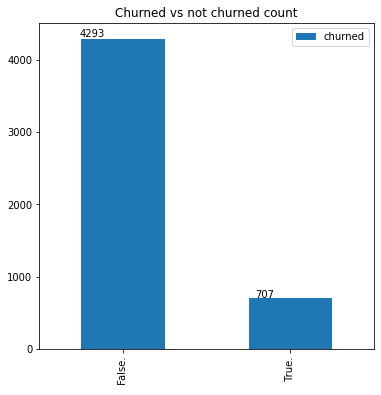

In [348]:
#check dependent variable counts 
df=pd.DataFrame(churn_df['churned'].value_counts())
ax=df.plot.bar()
ax.set_title('Churned vs not churned count')

#add bar labels
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.05, p.get_height() * 1.005))

clearly the dependent variable isn't balanced.

### Numerical Features

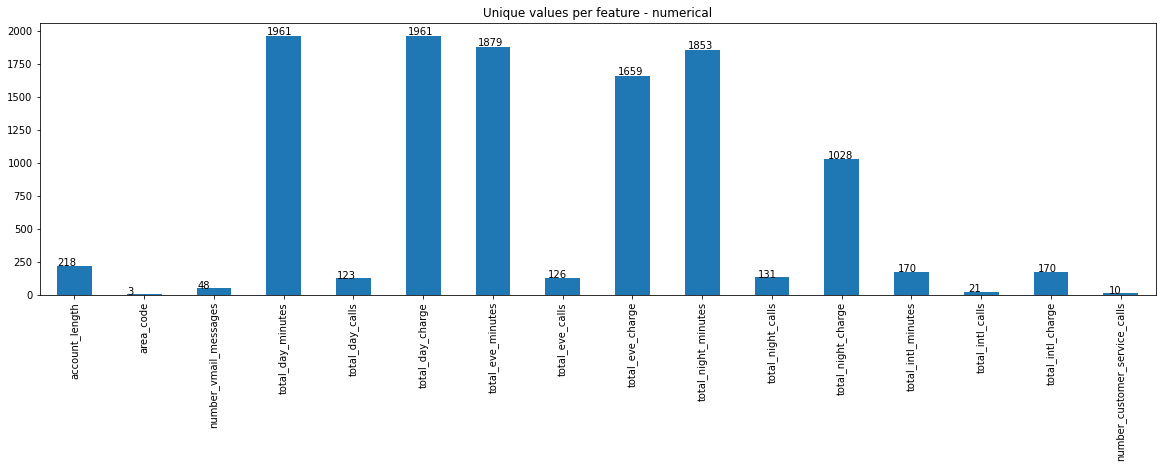

In [349]:
#check unique values per feature
col_num=churn_df.select_dtypes(include="number").columns
ax=churn_df.select_dtypes(include="number").nunique().plot.bar(logy=False, figsize=(20,5),title="Unique values per feature - numerical")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

--- 132.26109170913696 seconds ---


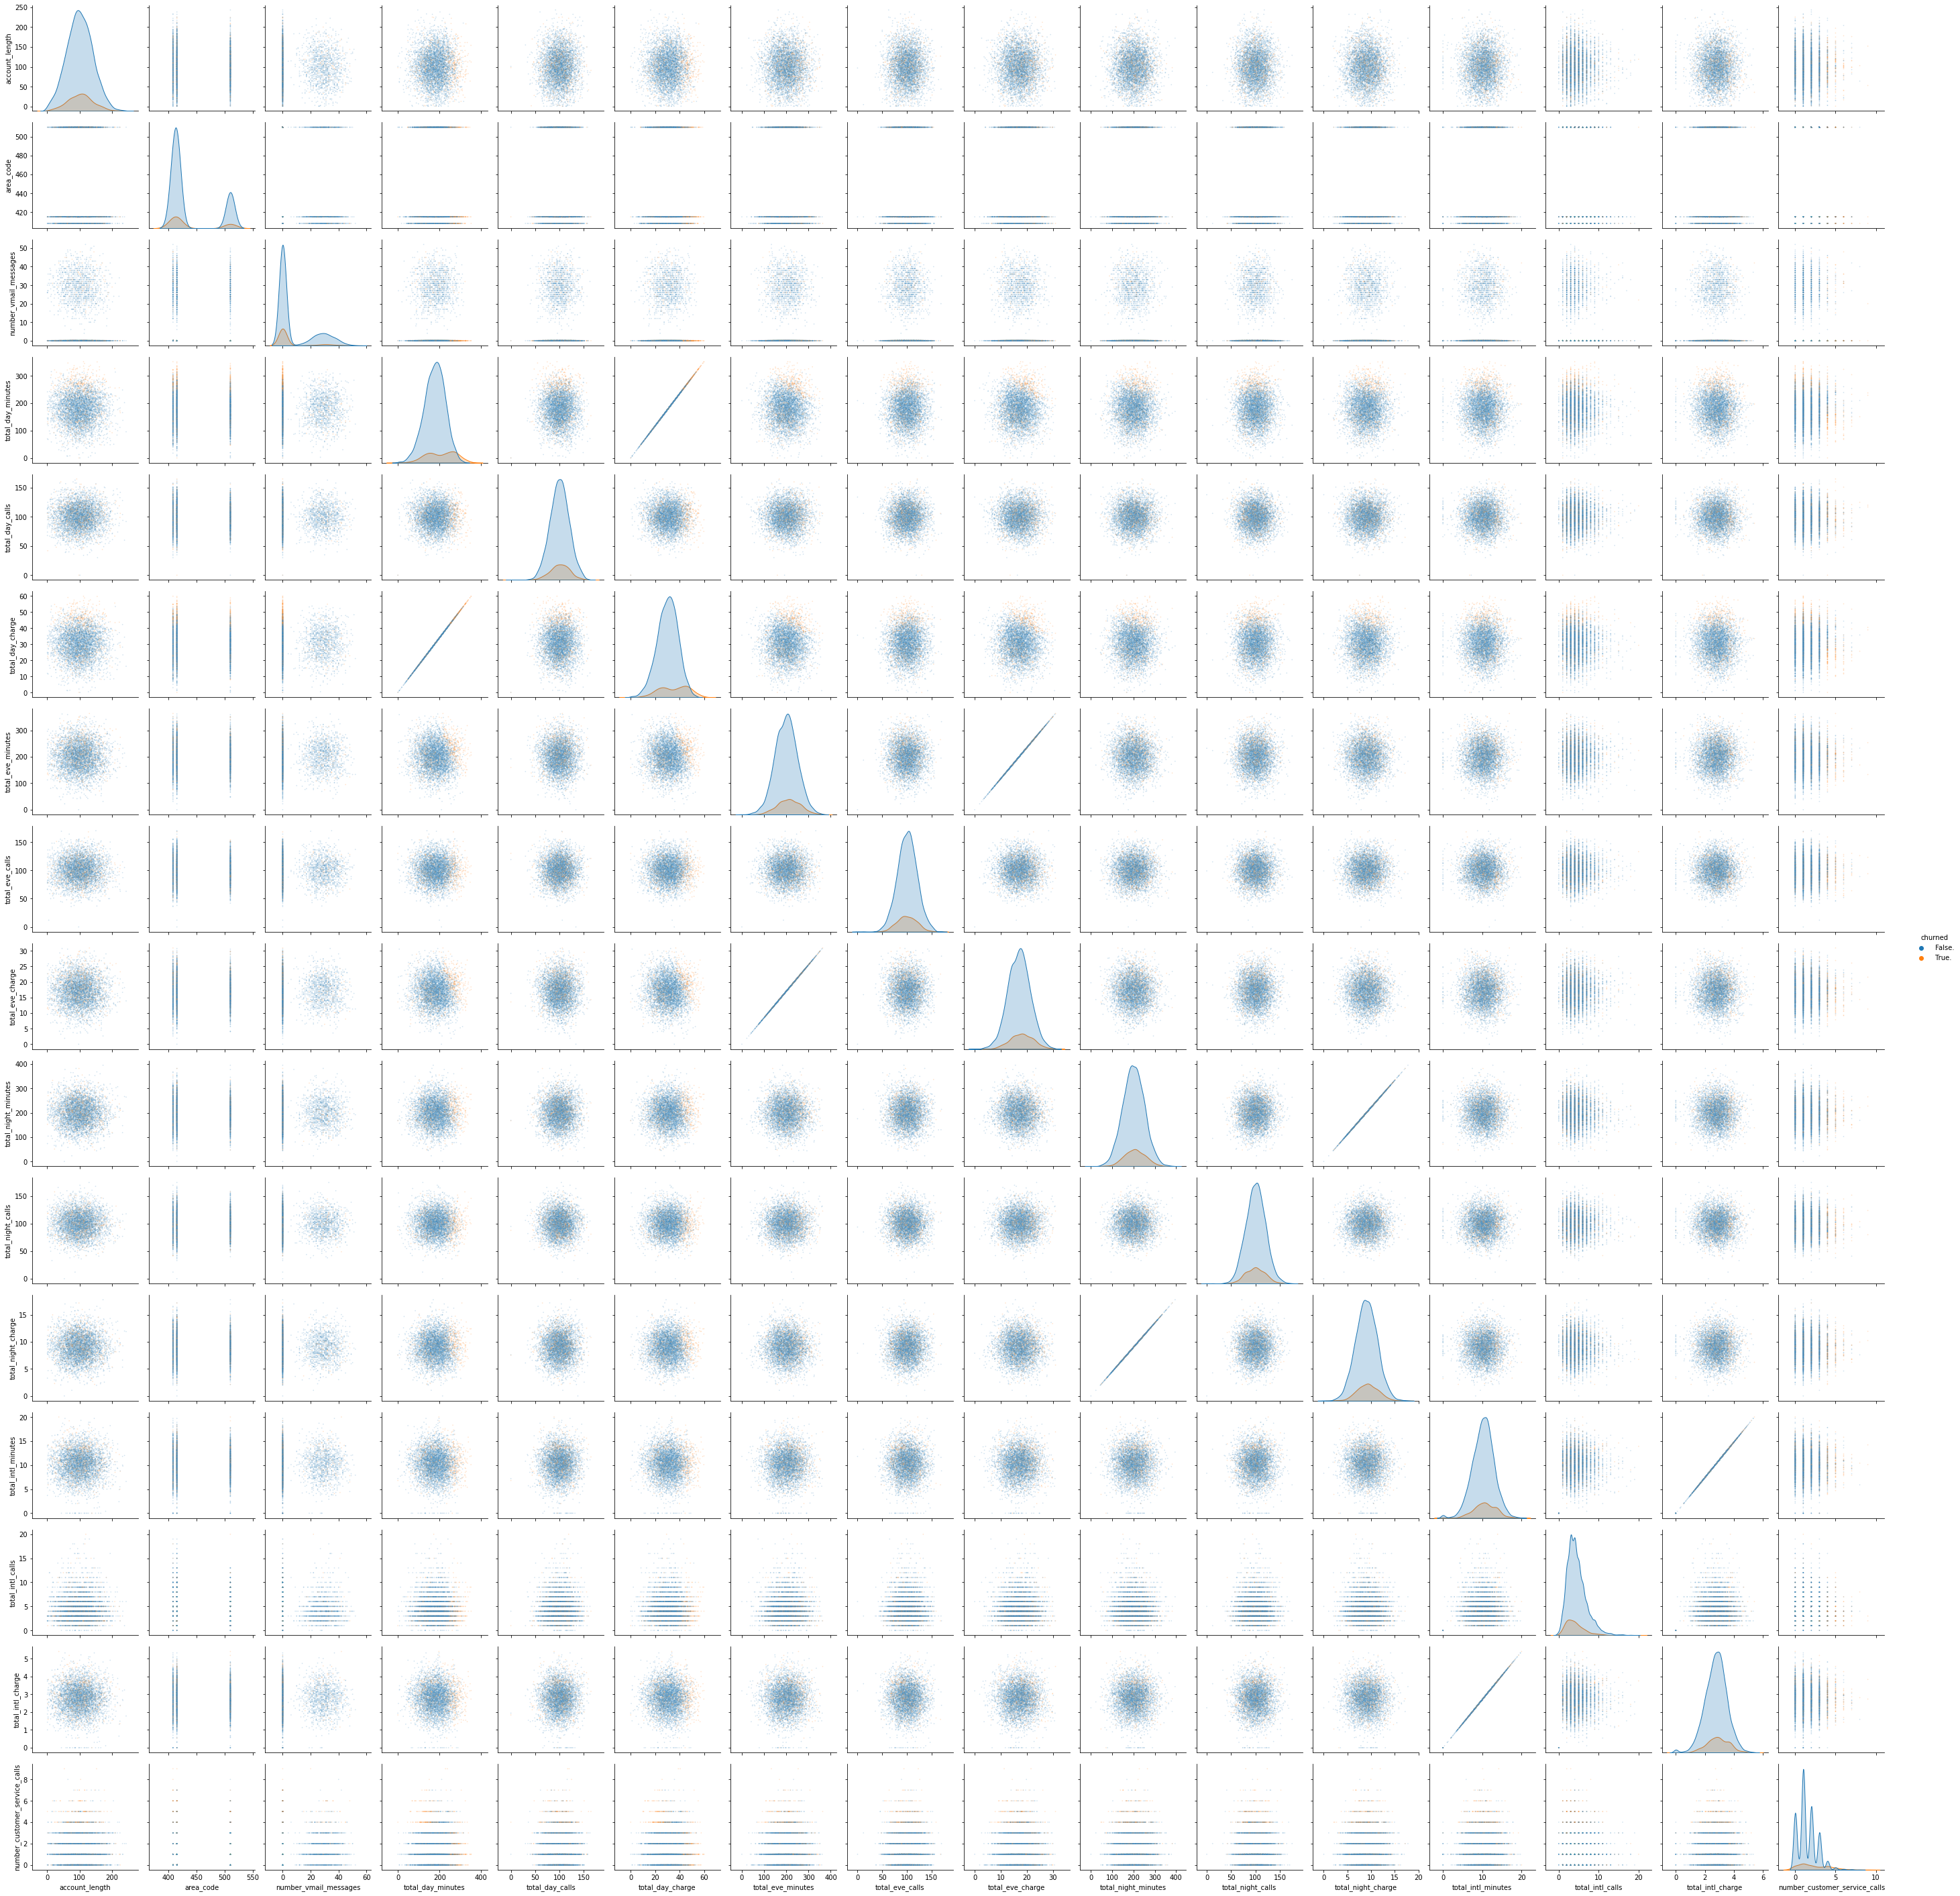

In [350]:
#since we have only 16 numerical features, let's just do a pairplot to understand numerical features
start_time=time.time()
sns.pairplot(
    churn_df, hue='churned',
  	plot_kws={"s": 3, "alpha": 0.2})
print("--- %s seconds ---" % (time.time() - start_time))

From pairplot, churned people do seem to cluster for some features. For example, total_day_minutes. Let's do somehistorgrams to take a closer look.

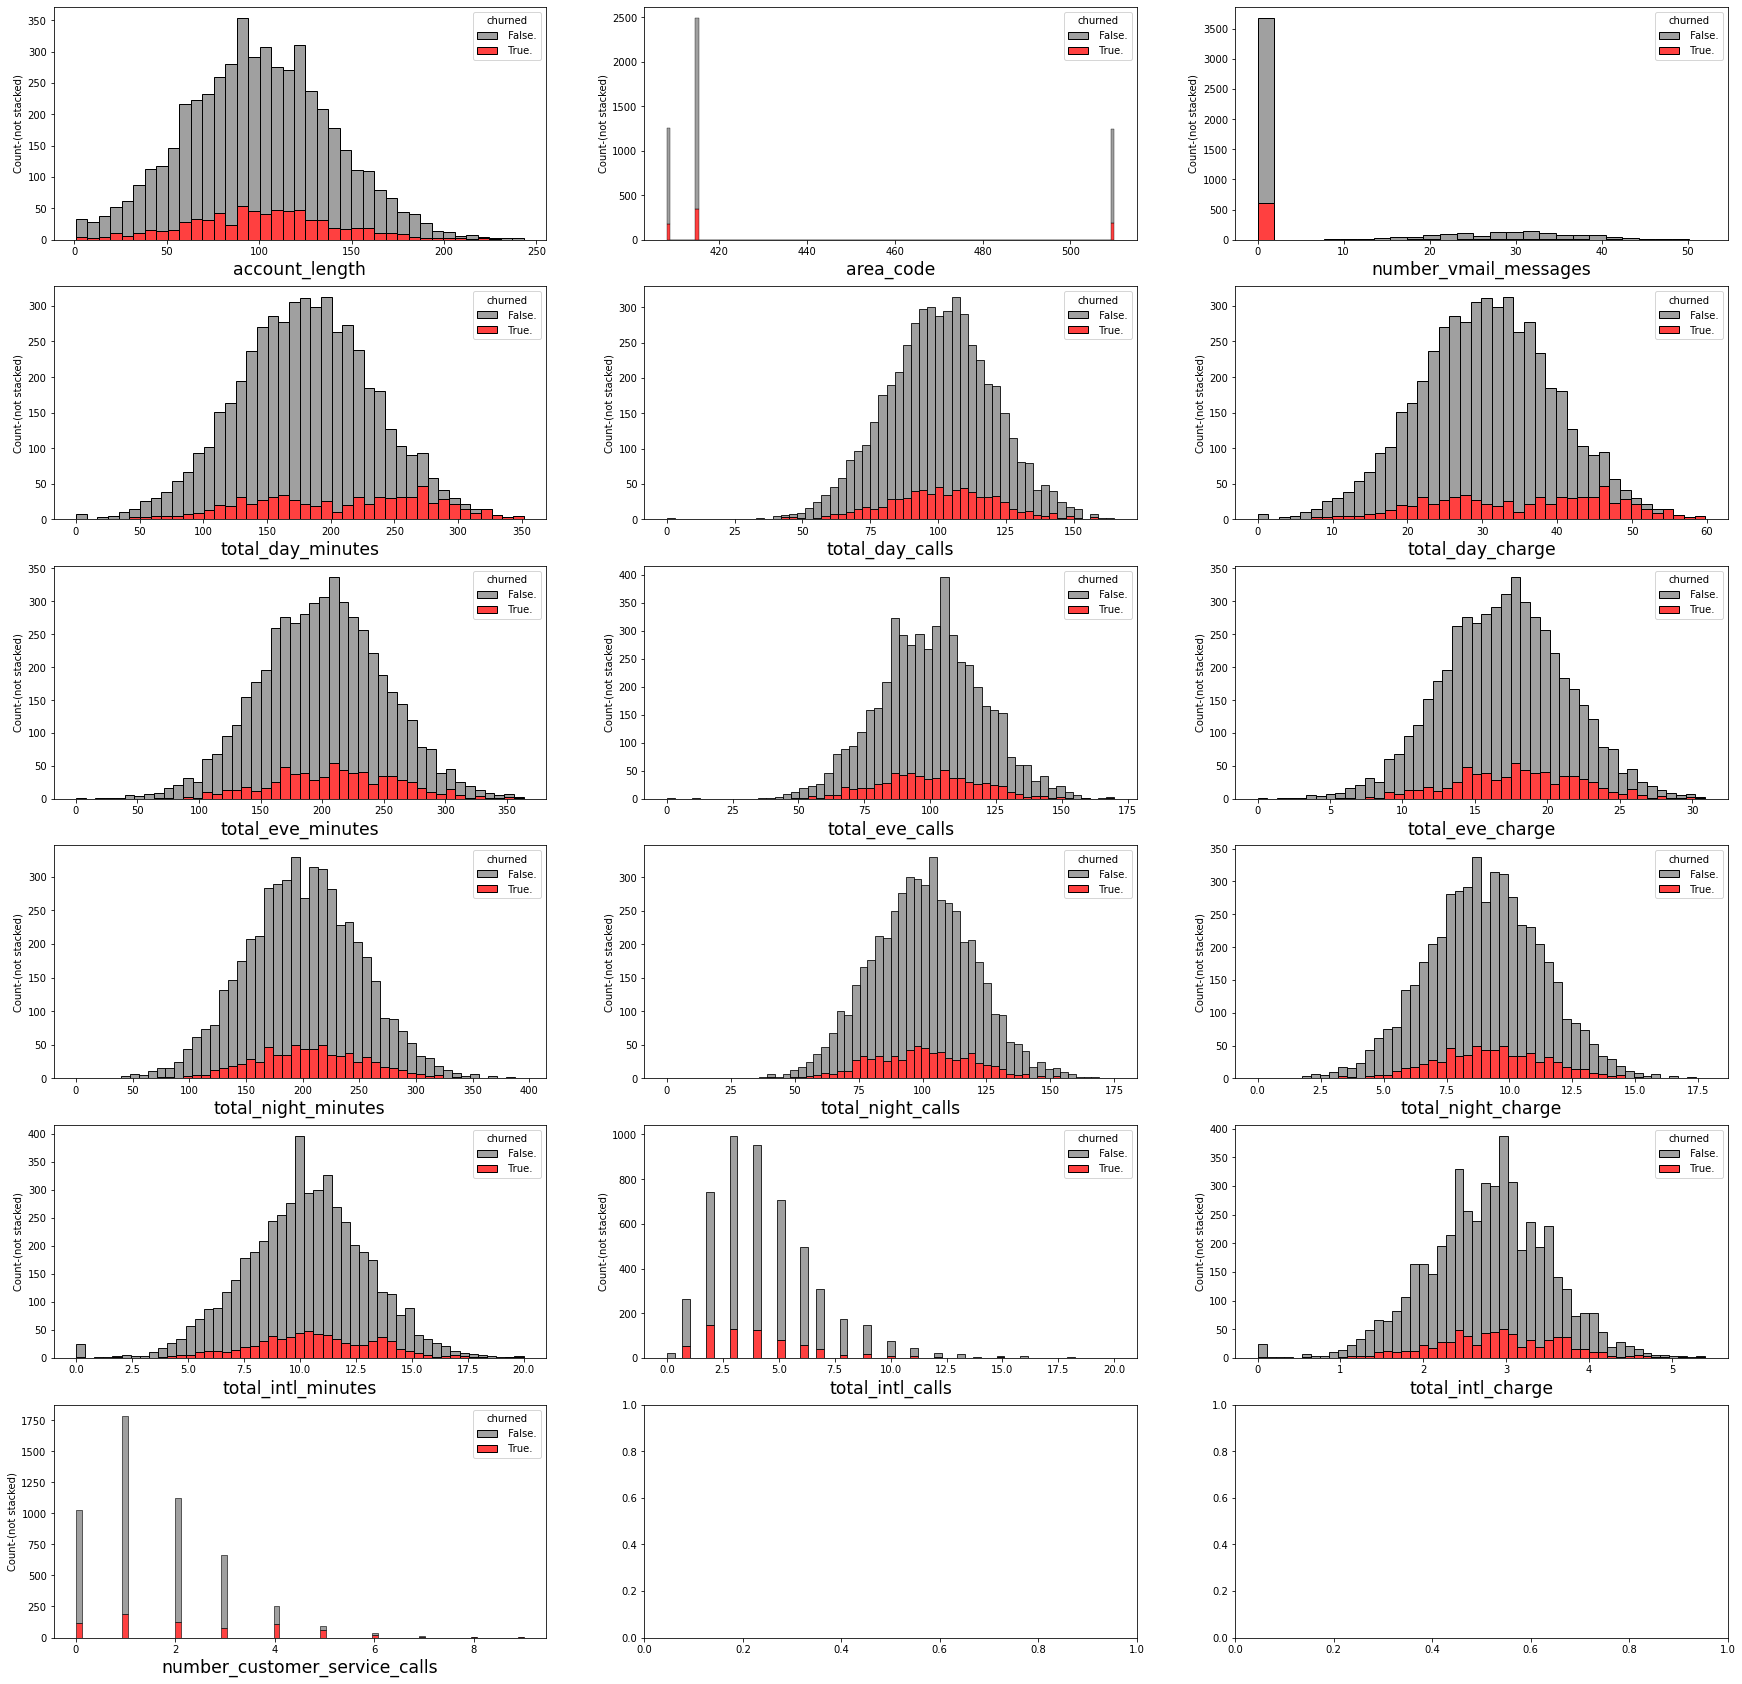

In [351]:
#Draw histograms for numerical features 
grh_per_row =3
fig, ax = plt.subplots(len(col_num)//grh_per_row+1,grh_per_row, figsize = (30, 30))

for count, feature in enumerate(col_num, 0):
    data= churn_df.copy()
    row=count // grh_per_row
    col=(count )% grh_per_row    
    sns.histplot(data=data, x=data[feature],ax=ax[row,col], palette=['gray','red'],hue="churned",multiple='stack') 
    ax[row,col].set_xlabel(feature, fontsize='xx-large')   
    ax[row,col].set_ylabel("Count-(not stacked)") 
    
plt.show()

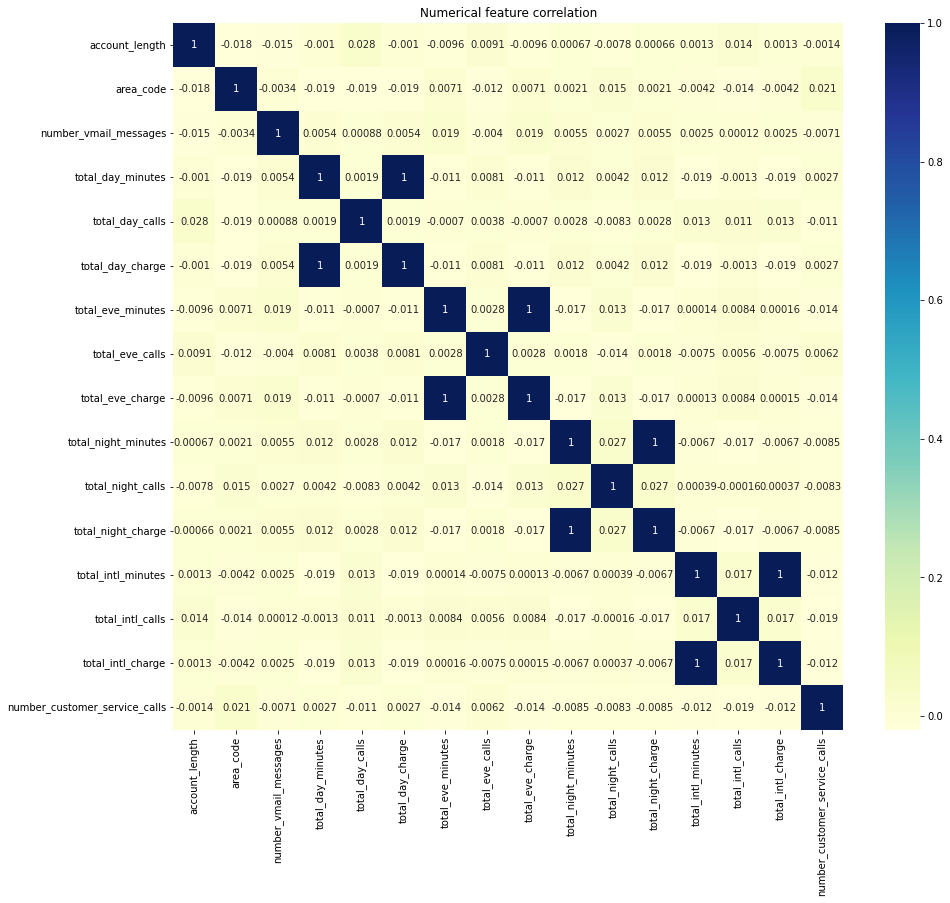

In [352]:
# Use heatmap to check numerical feature correlations
corr=churn_df[col_num].corr()
plt.figure(figsize=(15,13))
plt.title("Numerical feature correlation")
sns.heatmap(data=corr, annot=True, cmap="YlGnBu")

It seems churned customer seem to have more total_day_minutes, total_day_charge, total_intl_minutes,total_intl_charge,number_customer_service_calls. But since they don't seem to have more calls. My guess is they have more long calls. 

Features don't generally have very strong correlation. But some do as expected. For instance, total_day_minutes vs. total_day_charges.

### Categorical Features


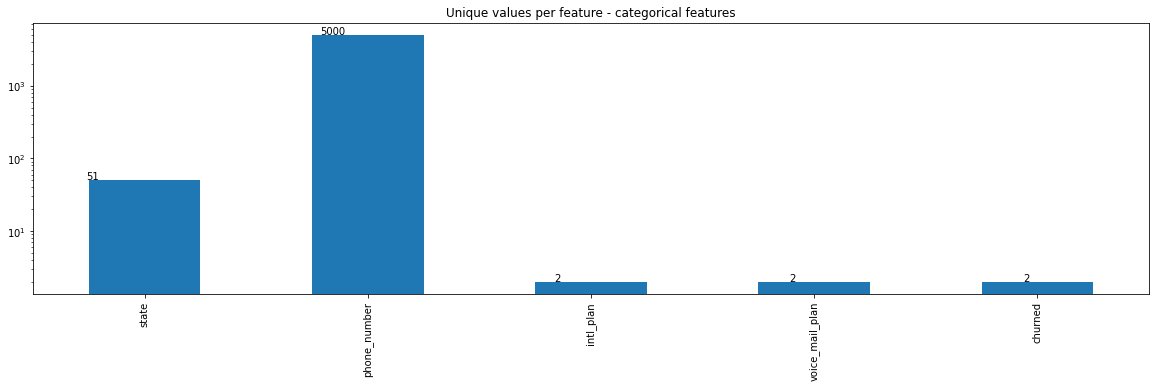

In [353]:
#check unique values per feature
col_cat= churn_df.select_dtypes(include="object")
ax=churn_df.select_dtypes(include="object").nunique().plot.bar(logy=True, figsize=(20,5),title="Unique values per feature - categorical features")

#add bar labels
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.05, p.get_height() * 1.005))

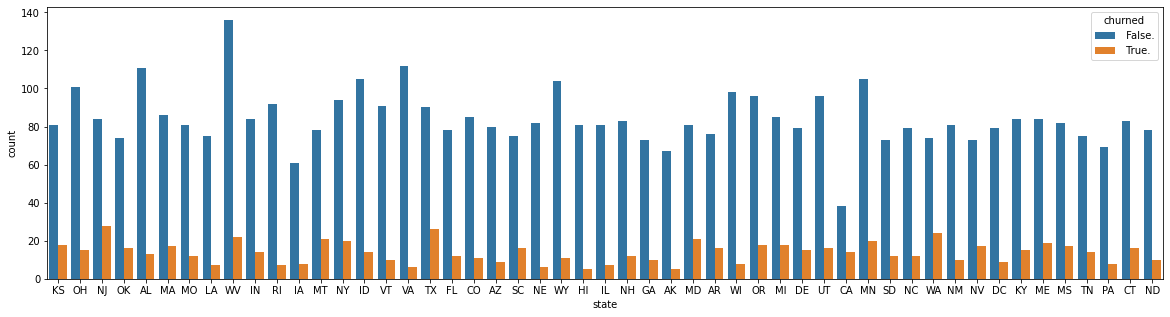

In [354]:
plt.figure(figsize=(20,5))
sns.countplot(data=churn_df, x='state', hue='churned')

Text(0.5, 1.0, 'Count of intl_plan - Churned vs. not')

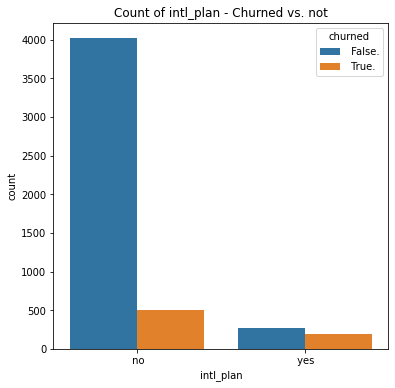

In [355]:
ax=sns.countplot(data=churn_df, x='intl_plan', hue='churned')
ax.set_title("Count of intl_plan - Churned vs. not")

Text(0.5, 1.0, 'Count of voice_mail_plan - Churned vs. not')

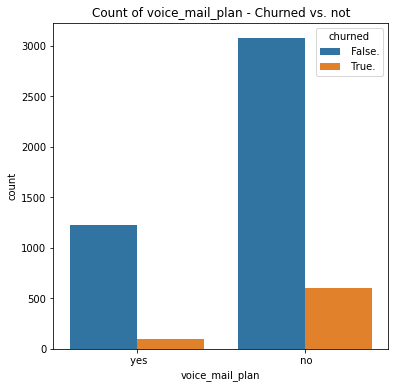

In [356]:
ax=sns.countplot(data=churn_df, x='voice_mail_plan', hue='churned')
ax.set_title("Count of voice_mail_plan - Churned vs. not")

seems people with "intl_plan" and with no "voice_mail_plan" have more proportion of peopole to churn.

In [357]:
#From above graph, people without voice mail plan seem to have greater portion of churned customers. Let's see the actual #s 
churn_df.groupby(['voice_mail_plan','churned'])['voice_mail_plan'].count()

voice_mail_plan  churned
 no               False.    3072
                  True.      605
 yes              False.    1221
                  True.      102
Name: voice_mail_plan, dtype: int64

It seem customers with voice mail plan have less than 10% churned one while it's 2% for no voice mail plan one. Voice mail plan is a good predictor.

Also, intl_plan is a good predictive feature too. We should probably drop phone number and State. 

# Part 2: Feature Preprocessing

### Categorical feature encoding

In [358]:
#Will code 'yes' to 1 and 'no' to 0 for voice mail plan
#take a look to make sure name is okay
print(f"Has voice mail plan: {sum(churn_df['voice_mail_plan']==' no')} ")

#take a look at a 
churn_df.voice_mail_plan[1]

Has voice mail plan: 3677 


' yes'

In [359]:
churn_df['intl_plan'][0]

' no'

In [360]:
churn_df['churned'][0]

' False.'

In [361]:
# Remove extra white space
for col in ['voice_mail_plan', 'intl_plan','churned']:
    churn_df[col]=churn_df[col].map(lambda x: x.strip())

In [362]:
#Remove extra white space
churn_df['churned'] = churn_df['churned'].map(lambda x: x.split('.')[0])
churn_df['churned'][0]

'False'

In [363]:
#categorical feature encoding
#encode voice_mail_plan and intl_plan fetures to boolean
feature_to_encode= ['voice_mail_plan', 'intl_plan']
churn_df[feature_to_encode]=churn_df[feature_to_encode]=="yes"

#encode churned variable to boolean
churn_df['churned'] = churn_df['churned']=='True'


### Drop unuseful columns
From previous EDA, state and phone_number aren't good predictors. We will just drop them

In [364]:
#drop useless features
col_useless=['state','phone_number']
churn_df.drop(col_useless, axis=1, inplace=True)

# Part 3: Model Training 

### Split data

In [365]:
# Split dataset
y=churn_df['churned']
X=churn_df.drop(['churned'],axis=1)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

print('training data has %d observation with %d features'% X_train.shape)
print('test data has %d observation with %d features'% X_test.shape)

training data has 4000 observation with 18 features
test data has 1000 observation with 18 features


In [366]:
churn_df['churned'].sum()

707

In [367]:
#Scale the data, using standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Logistic Regression

In [368]:
#build model classes

#Logistic Regression
classifier_logistic = LogisticRegression()

#K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

#Random Forest
classifier_RF = RandomForestClassifier()

#SVM
SVC=SVC()

In [369]:
# Train the model
classifier_logistic.fit(X_train, y_train)
classifier_logistic.predict(X_train)
classifier_logistic.score(X_train, y_train)

0.8685

In [370]:
# Prediction of test data
classifier_logistic.predict(X_test)
classifier_logistic.score(X_test, y_test)


0.853

In [371]:
# Use 5-fold Cross Validation to get the accuracy for different models
model_names = ['Logistic Regression','KNN','Random Forest', 'SVM']
model_list = [classifier_logistic, classifier_KNN, classifier_RF, SVC]
count = 0

for classifier in model_list:
    cv_score = model_selection.cross_val_score(classifier, X_train, y_train, cv=5)
    # cprint(cv_score)
    print('Model accuracy of %s is: %.3f'%(model_names[count],cv_score.mean()))
    count += 1

Model accuracy of Logistic Regression is: 0.867
Model accuracy of KNN is: 0.892
Model accuracy of Random Forest is: 0.957
Model accuracy of SVM is: 0.919


*italicized text*### (Optional) Part 3.3: Use Grid Search to Find Optimal Hyperparameters

In [372]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

#### Part 3.3.1: Find Optimal Hyperparameters - LogisticRegression

In [373]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(1, 5, 10)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': (1, 5, 10), 'penalty': ('l1', 'l2')})

In [374]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.867
Best parameters set:
	C: 10
	penalty: 'l2'


In [375]:
# best model
best_LR_model = Grid_LR.best_estimator_

#### Part 3.3.2: Find Optimal Hyperparameters: KNN

In [376]:
# Possible hyperparamter options for KNN
# Choose k
parameters = {
    'n_neighbors':[3,5,7,10] 
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5)
Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 10]})

In [377]:
# best k
print_grid_search_metrics(Grid_KNN)

Best score: 0.892
Best parameters set:
	n_neighbors: 5


#### Part 3.3.3: Find Optimal Hyperparameters: Random Forest

In [378]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [40,60,80]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [40, 60, 80]})

In [379]:
# best number of tress
print_grid_search_metrics(Grid_RF)

Best score: 0.957
Best parameters set:
	n_estimators: 60


In [380]:
# best random forest
best_RF_model = Grid_RF.best_estimator_

### Part 3.4: Model Evaluation - Confusion Matrix (Precision, Recall, Accuracy)

class of interest as positive

TP: correctly labeled real churn

Precision(PPV, positive predictive value): tp / (tp + fp);
Total number of true predictive churn divided by the total number of predictive churn;
High Precision means low fp, not many return users were predicted as churn users. 


Recall(sensitivity, hit rate, true positive rate): tp / (tp + fn)
Predict most postive or churn user correctly. High recall means low fn, not many churn users were predicted as return users.

In [381]:
# calculate accuracy, precision and recall
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

Random Forest
Accuracy is: 0.953
precision is: 0.922
recall is: 0.761


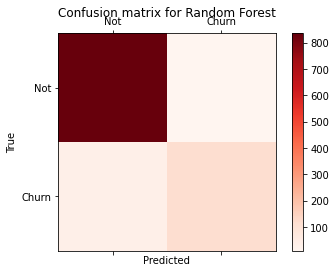

Logistic Regression
Accuracy is: 0.852
precision is: 0.566
recall is: 0.194


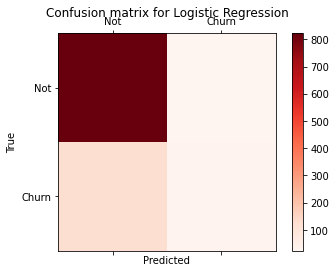

In [382]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Random Forest", confusion_matrix(y_test,best_RF_model.predict(X_test))),
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(X_test))),
]

draw_confusion_matrices(confusion_matrices)

### Part 3.4: Model Evaluation - ROC & AUC

RandomForestClassifier, KNeighborsClassifier and LogisticRegression have predict_prob() function 

#### Part 3.4.1: ROC of RF Model

In [383]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Random Forest
y_pred_rf = best_RF_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

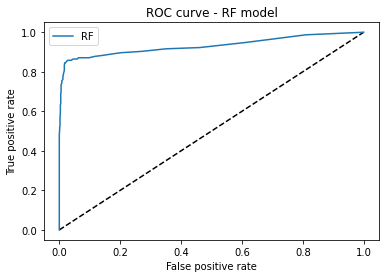

In [384]:
# ROC curve of Random Forest result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()

In [385]:
from sklearn import metrics

# AUC score
metrics.auc(fpr_rf,tpr_rf)

0.9316205382706623

#### Part 3.4.1: ROC of LR Model

In [386]:
# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

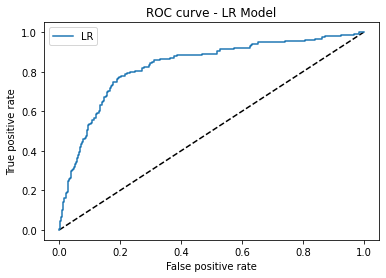

In [387]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [388]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.8288299293758351

# Part 4: Feature Coefficients/Importance

### Logistic Regression Model with L1

In [389]:
# add L1 regularization to logistic regression
# check the coef for feature selection
scaler = StandardScaler()
X_l1 = scaler.fit_transform(X_train)
LRmodel_l1 = LogisticRegression(penalty="l1", C = 0.1,  solver='liblinear')
LRmodel_l1.fit(X_l1, y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

### Logistic Regression Model with L2

In [390]:
# add L2 regularization to logistic regression
# check the coef for feature selection
scaler = StandardScaler()
X_l2 = scaler.fit_transform(X_train)
LRmodel_l2 = LogisticRegression(penalty="l2", C = 5)
LRmodel_l2.fit(X_l2, y_train)

LogisticRegression(C=5)

### Random Forest 

In [391]:
# check feature importance of random forest for feature selection
forest = RandomForestClassifier()
forest.fit(X, y)
importances = np.round(forest.feature_importances_,1)

### Visualize feature importance/coefficients 

In [392]:
# Function to display coefficients or feature importance
def display_importance(coefi, model_name):
   coef = pd.Series(data=coefi, index = X.columns)
   imp_coef = coef.sort_values()
   matplotlib.rcParams['figure.figsize'] = (6, 6)
   ax=imp_coef.plot(kind = "barh", color="violet")
   plt.title(f"Feautre coefficients in the {model_name}")

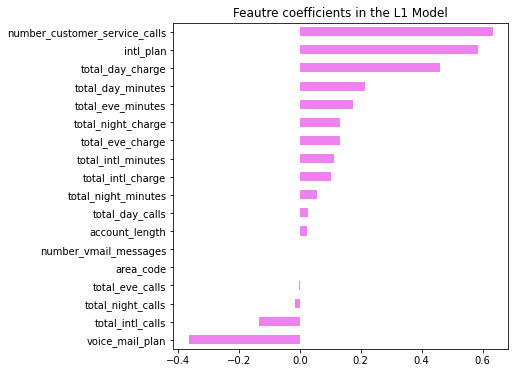

In [393]:
display_importance(LRmodel_l1.coef_[0], "L1 Model")

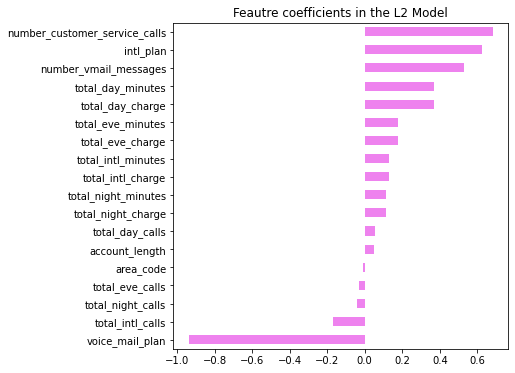

In [394]:
display_importance(LRmodel_l2.coef_[0], "L2 Model")

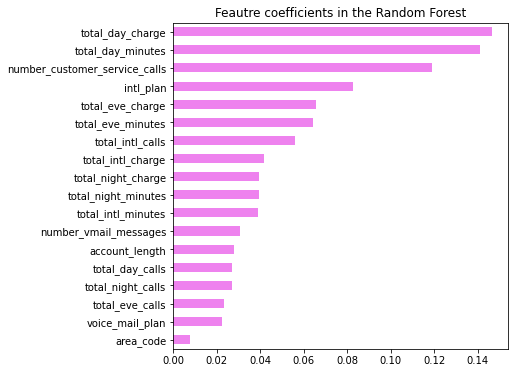

In [395]:
display_importance(forest.feature_importances_, "Random Forest")